In [1]:
import os
import random

import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision
import re
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from collections import OrderedDict
from torch import Tensor
from typing import Any, List, Tuple

from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms

from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
import torchvision.transforms as T
import sklearn.utils as utils

In [2]:
torch.cuda.empty_cache()
random_seed = 42
batch_size = 50
train_root = 'train_images'
NUM_EPOCHS = 10
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
train_table = pd.read_csv('train.csv')
train_table.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [4]:
train_table.shape

(21396, 2)

In [5]:
train_table['label'].value_counts()

3    13158
4     2576
2     2386
1     2189
0     1087
Name: label, dtype: int64

In [6]:
train_paths = [os.path.join(train_root, file) for file in train_table['image_id']]
train_labels = train_table['label'].values

In [7]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
    transforms.Scale(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

def default_loader(path):
    img_pil =  Image.open(path)
    img_pil = img_pil.resize((224,224))
    img_tensor = preprocess(img_pil)
    return img_tensor

C:\Users\woqip\anaconda3\lib\site-packages\torchvision\transforms\transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [8]:
class MyDataset(Dataset):
    def __init__(self, img_paths, labels, loader=default_loader):
        self.img_paths = img_paths
        self.labels = labels
        self.loader = loader
        
    def __getitem__(self, index):
        img_path, label = self.img_paths[index], self.labels[index]
        img = self.loader(img_path)
        
        return img, label
    
    def __len__(self):
        return len(self.labels)

In [9]:
dataset = MyDataset(train_paths, train_labels)
len(dataset)*np.array([0.8,0.05,0.15])

array([17116.8,  1069.8,  3209.4])

In [10]:
train_dataset, val_dataset, test_dataset = random_split(dataset, [17000 ,  1070,  3326], generator=torch.Generator().manual_seed(random_seed))

In [11]:
train_loader = DataLoader(train_dataset, batch_size=batch_size)
valid_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [12]:
model = torch.hub.load('pytorch/vision:v0.9.0', 'shufflenet_v2_x1_0', pretrained=True)
model = model.to(device)

Using cache found in C:\Users\woqip/.cache\torch\hub\pytorch_vision_v0.9.0
Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to C:\Users\woqip/.cache\torch\hub\checkpoints\shufflenetv2_x1-5666bf0f80.pth


In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

Epoch: 001/010 | Batch 0000/0340 | Loss: 8.8317
Epoch: 001/010 | Batch 0100/0340 | Loss: 1.5253
Epoch: 001/010 | Batch 0200/0340 | Loss: 0.7007
Epoch: 001/010 | Batch 0300/0340 | Loss: 0.7669
Epoch: 001/010 | Train: 81.78% | Validation: 75.05%
Time elapsed: 6.70 min
Epoch: 002/010 | Batch 0000/0340 | Loss: 0.6716
Epoch: 002/010 | Batch 0100/0340 | Loss: 0.6639
Epoch: 002/010 | Batch 0200/0340 | Loss: 0.3568
Epoch: 002/010 | Batch 0300/0340 | Loss: 0.4377
Epoch: 002/010 | Train: 88.72% | Validation: 75.98%
Time elapsed: 13.36 min
Epoch: 003/010 | Batch 0000/0340 | Loss: 0.3762
Epoch: 003/010 | Batch 0100/0340 | Loss: 0.4380
Epoch: 003/010 | Batch 0200/0340 | Loss: 0.2135
Epoch: 003/010 | Batch 0300/0340 | Loss: 0.2688
Epoch: 003/010 | Train: 93.95% | Validation: 76.54%
Time elapsed: 21.12 min
Epoch: 004/010 | Batch 0000/0340 | Loss: 0.1983
Epoch: 004/010 | Batch 0100/0340 | Loss: 0.2627
Epoch: 004/010 | Batch 0200/0340 | Loss: 0.1149
Epoch: 004/010 | Batch 0300/0340 | Loss: 0.1537
Epoch

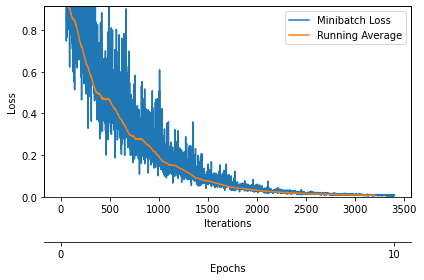

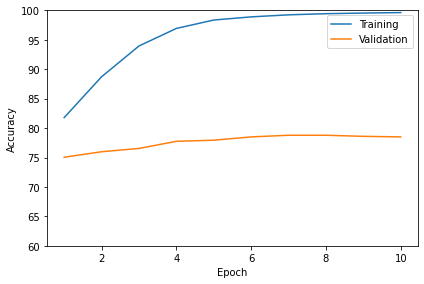

In [14]:

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=device,
    scheduler=scheduler,
    scheduler_on='valid_acc',
    logging_interval=100)

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=200)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([60, 100])
plt.show()

In [15]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   37378 KB |    1025 MB |   16387 GB |   16387 GB |
|       from large pool |   24957 KB |    1013 MB |   16331 GB |   16331 GB |
|       from small pool |   12421 KB |      15 MB |      56 GB |      56 GB |
|---------------------------------------------------------------------------|
| Active memory         |   37378 KB |    1025 MB |   16387 GB |   16387 GB |
|       from large pool |   24957 KB |    1013 MB |   16331 GB |

In [16]:
torch.cuda.empty_cache()